In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import colorcet as cc
from healpy import projaxes as PA

In [2]:
# Modify Healpy's `mollview` function to allow more control of margins
def mollview(
    bounds,
    map=None,
    unit="",
    xsize=800,
    title="",
    min=None,
    max=None,
    cbar=True,
    cmap=None,
    extend='neither',
):
    # Ensure that the nside is valid
    nside = hp.get_nside(map)

    f = plt.gcf()
    left, bottom, right, top = bounds
    extent = (left, bottom, right - left, top - bottom)

    map = hp.pixelfunc.ma_to_array(map)
    ax = PA.HpxMollweideAxes(f, extent)
    f.add_axes(ax)
    img = ax.projmap(map, xsize=xsize, vmin=min, vmax=max, cmap=cmap, badcolor="lightgray")
    if cbar:
        im = ax.get_images()[0]
        b = im.norm.inverse(np.linspace(0, 1, im.cmap.N + 1))
        v = np.linspace(im.norm.vmin, im.norm.vmax, im.cmap.N)
        cb = f.colorbar(
            im,
            ax=ax,
            orientation="horizontal",
            shrink=0.5,
            aspect=25,
            ticks=PA.BoundaryLocator(2, None),
            pad=0.05,
            fraction=0.1,
            boundaries=b,
            values=v,
            extend=extend
        )
        cb.solids.set_rasterized(True)
        cb.ax.text(0.5, -1.0, unit, transform=cb.ax.transAxes, ha="center", va="top")
    ax.set_title(title)
    f.sca(ax)

In [3]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{sansmath}\sansmath')
params = {
    'legend.fontsize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
}
plt.rcParams.update(params)

In [4]:
# Data locations
psm_dir = Path('../simulations/outputnops512_dm7')
base_result_path = Path('../model/2020-02-27-15-30-45_dm7')
commander_map_path = '/data/planck/COM_CMB_IQU-commander_2048_R3.00_full.fits'

In [5]:
# Beam window (arcmin)
beam_window = 13.1

## Simulation map with Model 8 thermal dust

In [6]:
y_raw = hp.read_map(psm_dir / f'sim0999/cmb.fits', verbose=False)

/etc/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [7]:
# Load results
result = hp.read_map(base_result_path / 'test0999_dm8.fits')

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/etc/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


## Evaluation using Planck maps

In [8]:
# Load results
result_planck = hp.read_map(base_result_path / 'planck.fits')
result_planck_err = hp.read_map(base_result_path / 'planck_err.fits')

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [9]:
strip_mask = np.zeros(hp.nside2npix(512), dtype=np.bool)
strip_mask[hp.query_strip(512, np.deg2rad(100), np.deg2rad(80))] = True
strip_mask = hp.reorder(strip_mask, r2n=True)
result_median = np.nanmedian(result_planck[strip_mask])

In [10]:
commander_map = hp.ud_grade(hp.smoothing(hp.read_map(commander_map_path, field=0), np.deg2rad(beam_window / 60), use_pixel_weights=True), 512) * 1e6

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/etc/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
Sigma is 5.563058 arcmin (0.001618 rad) 
-> fwhm is 13.100000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


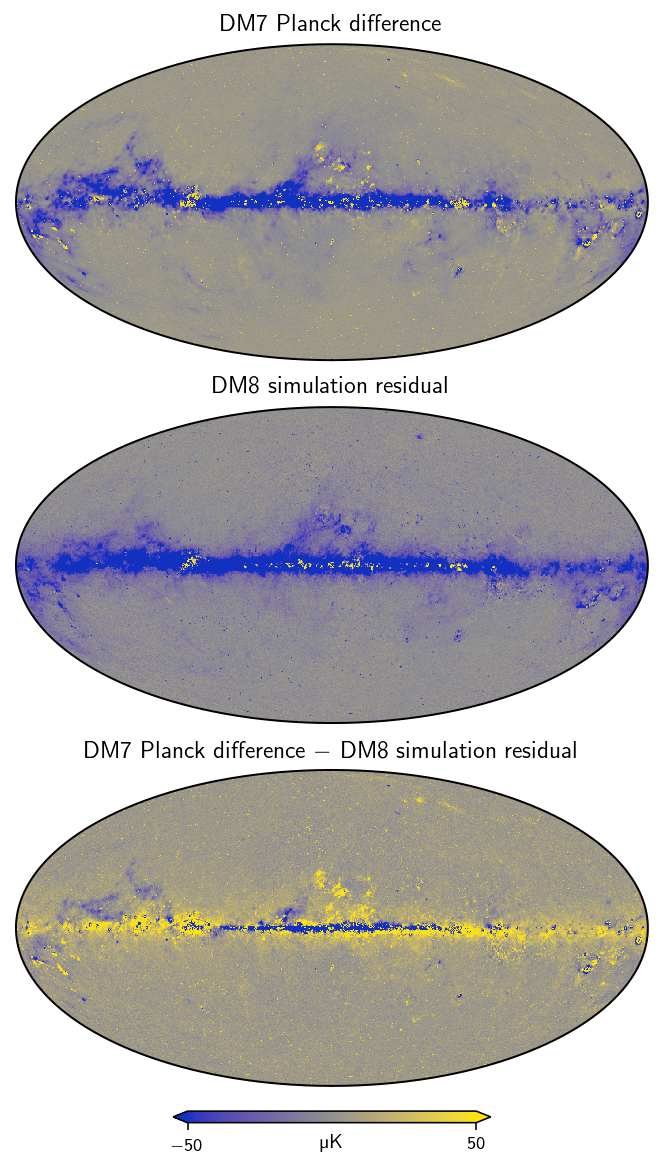

In [11]:
plt.figure(figsize=(4.5, 8.0))

f = plt.gcf()
f.delaxes(f.gca())

mollview((0.01, 0.69, 0.99, 0.97), result_planck - result_median - commander_map, min=-50.4, max=50.4, unit='\si{\micro\kelvin}', title='DM7 Planck difference', cmap='cet_bjy', cbar=False)

# Draw border: this could be done using hp.graticule, but it has slight
# rendering artifacts at top and bottom of border
theta = np.linspace(0, np.pi, 300)
plt.gca().projplot(np.append(theta[::-1], theta), np.append(np.repeat(-np.pi, 300), np.repeat(0.999999 * np.pi, 300)), "-k", lw=1, direct=True, solid_capstyle='round', solid_joinstyle='round')

mollview((0.01, 0.35, 0.99, 0.68), result - y_raw, min=-50.4, max=50.4, unit='\si{\micro\kelvin}', title='DM8 simulation residual', cmap='cet_bjy', cbar=False)
plt.gca().projplot(np.append(theta[::-1], theta), np.append(np.repeat(-np.pi, 300), np.repeat(0.999999 * np.pi, 300)), "-k", lw=1, direct=True, solid_capstyle='round', solid_joinstyle='round')

mollview((0.01, 0.0, 0.99, 0.41), (result_planck - result_median - commander_map) - (result - y_raw), min=-50.4, max=50.4, unit='\si{\micro\kelvin}', title='DM7 Planck difference $-$ DM8 simulation residual', cmap='cet_bjy', extend='both')
plt.gca().projplot(np.append(theta[::-1], theta), np.append(np.repeat(-np.pi, 300), np.repeat(0.999999 * np.pi, 300)), "-k", lw=1, direct=True, solid_capstyle='round', solid_joinstyle='round')

plt.savefig('dust-model-comparison-maps.pdf', dpi=300)

## Mean predicted error

In [12]:
np.mean(result_planck_err)

11.221834689126505